<a href="https://colab.research.google.com/github/doeungim/ADP_DE2/blob/main/ADP_PRAC_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [136]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score


In [3]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/ADP_SONY/ADP_SET_1/data/bitcoin_mock.csv')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### ✅  1. 모든 데이터 행이 1분간격으로 존재하는지 확인하고 그렇지 않은 경우 누락된 시각의 행을 생성하고 컬럼들의 결측치를 적절히 생성하라. 결측치가 존재한다면 결측치를 처리하라

In [45]:
df['datetime'] = pd.to_datetime(df['datetime'])

# 60초 = 1분 간격으로 확인
df['diff']= df['datetime'].diff(1).dt.seconds


print(df['diff'].value_counts())
# 120 간격 확인
#그렇지 않은 경우 누락된 시각의 행을 생성
# 1분 간격의 데이터 Range로 생성
min = df['datetime'].min()
max = df['datetime'].max()

new_date = pd.DataFrame(pd.date_range(start = min, end = max, freq = '1T') , columns = ['new_date'])

total = pd.merge(new_date, df, how = 'left', left_on = 'new_date', right_on = 'datetime')

# total['new_date'].diff(1).dt.seconds.value_counts()

total = total.drop(columns = ['datetime','diff'])

# 결측치가 존재한다면 결측치를 처리
total= total.interpolate().reset_index(drop = True)

diff
60.0     613102
120.0        25
Name: count, dtype: int64


<ipython-input-45-4591efb21532>:14: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  new_date = pd.DataFrame(pd.date_range(start = min, end = max, freq = '1T') , columns = ['new_date'])


#### ✅  2. 전처리

      1. t(분)시점에서 close 값에 대한 t(분)시점의 5분,120분 이동평균값을 각각 't_5', 't_120'으로 컬럼으로 t-1(분)시점의 5분,120분 이동평균값을 각각 't-1_5', 't-1_120'으로 컬럼

      2. t(분)시점에서 5분 이동평균값(t_5)은 120분 이동평균값(t_120)보다 높고 t-1의 5분 이동평균값(t-1_5)은 120분 이동평균값(t-1_120)보다 낮은 경우 : 'buy' # 매수
      t(분)시점에서 5분 이동평균값(t_5)은 120분 이동평균값(t_120 보다 낮고 t-1의 5분 이동평균값(t-1_5)은 120분 이동평균값(t-1_120)보다 높은 경우 : 'sell' # 매도
      그외 'stay'  위의 조건으로 buy(매수), sell(매도)를 판단하고 buy,sell,stay를 나타내는 새로운 컬럼 'algorithm'을 생성

      3. t+10(분)의 open 값과 t(분)의 close값을 비교하여 새로운 컬럼 'result'를 만든다.

      여부가 'buy' 이고 t+10(분) open >= t(분) close : 'profit'
      여부가 'buy' 이고 t+10(분) open < t(분) close : 'loss'
      여부가 'sell' 이고 t+10(분) open >= t(분) close : 'loss'
      여부가 'sell' 이고 t+10(분) open < t(분) close : 'profit'
      여부가 'stay' 이면 : 'stay'

In [53]:
total['t_5'] = total['close'].rolling(5).mean()
total['t_120'] = total['close'].rolling(120).mean()

# t-1(분)시점의 5분,120분 이동평균값을 각각 't-1_5', 't-1_120'
total['t_1_5'] = total['t_5'].shift(1)
total['t_1_120'] = total['t_120'].shift(1)


In [64]:
# 2.
def algo(x) :
  t_5 = x['t_5']
  t_120 = x['t_120']
  t_1_5 = x['t_1_5']
  t_1_120 = x['t_1_120']

  if t_5 > t_120 and t_1_5 < t_1_120 :
    return 'buy'
  elif t_5 < t_120 and t_1_5 > t_1_120 :
    return 'sell'
  else :
    return 'stay'

total['algorithm'] = total.apply(algo, axis = 1)
total['algorithm'].value_counts()

,count
algorithm,
stay,598515
sell,7319
buy,7319


In [65]:
# 3.
total['t_10'] = total['open'].shift(-10)

def result(x) :
  algo = x['algorithm']
  t_10 = x['t_10']
  close = x['close']

  if algo =='buy' :
    if t_10 >= close :
      return 'profit'
    elif t_10 < close :
      return 'loss'

  elif algo =='sell' :
    if t_10 >= close :
      return 'loss'
    elif t_10 < close :
      return 'profit'

  elif algo == 'stay' :
    return 'stay'

total['result'] = total.apply(result, axis = 1)

#### ✅  3. Plot
    2022-01-01 08:00:00 ~ 2022-01-01 15:00:00 시간대의 close값의 선형 그래프
    위 시간대에 대해 algorithm 컬럼이 buy일 경우 빨간 수직선, sell일 경우 파란 수직선

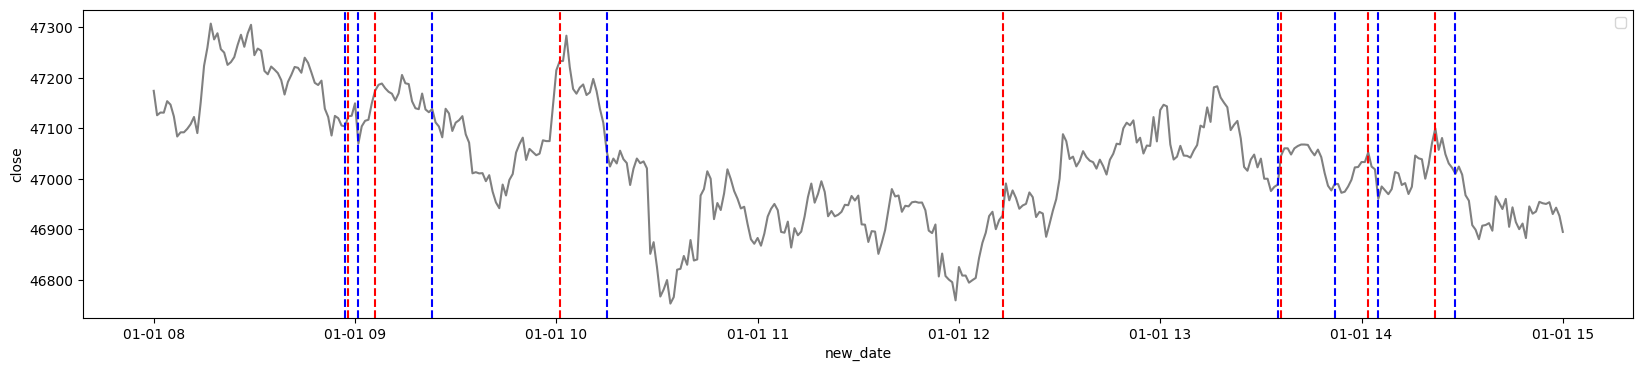

In [106]:
t2 = total.dropna()

start = pd.to_datetime('2022-01-01 08:00:00 ')
end = pd.to_datetime('2022-01-01 15:00:00')

plot_df = t2.loc[(t2['new_date'] >= start) & (t2['new_date'] <= end)].reset_index(drop = True)

plt.figure(figsize = (20, 4))

sns.lineplot(x = 'new_date', y = 'close', data = plot_df , color = 'grey')


for i in range(len(plot_df)) :
  if plot_df['algorithm'].iloc[i] == 'buy' :
    plt.axvline(x = plot_df['new_date'].iloc[i], color = 'red', linestyle= '--')

  elif plot_df['algorithm'].iloc[i] == 'sell' :
    plt.axvline(x = plot_df['new_date'].iloc[i], color = 'blue', linestyle= '--')

plt.legend()
plt.show()

In [107]:
# np.where : 조건 만족 인덱스로만 반환
plot_df.iloc[np.where(plot_df['algorithm'].isin(['buy', 'sell']))][['algorithm','close']]

# Filter : 컬럼을 필터링하는 함수
# 'apple'과 'cherry' 컬럼만 선택
filtered_df = df.filter(items=['apple', 'cherry'], axis=1)
# ap 문자열만 포함하는 컬럼을 선택
filtered_df_like = df.filter(like='ap', axis=1)


#### ✅  4. Modelling

    open
    시작가,종가 가격차이 (open - close)
    algorithm
    t분과 t-5분시점의 close값의 차이

    1. 2022년 2월 ~ 12월까지의 데이터를 train,
    2. 2023년 1~2월의 데이터를 평가 데이터로 하고 result의 값이
       loss,profit인 데이터만 학습에 사용하여
    3. 랜덤포레스트와 서포트 벡터머신 분류모델을 만들고 test데이터에 대해 accuracy를 비교하라.
    4. test데이터에 대한 예측 진행시 profit일 확률이 60%이상인 경우에만 profit으로 예측

In [143]:
t2['open_close'] = t2.open - t2.close
t2['t_5_close_diff'] = t2['close'] - t2['close'].shift(5)

m_df = t2[['new_date', 'open','open_close','t_5_close_diff','algorithm','result']].dropna().reset_index(drop = True)
m_df = m_df[m_df['result'].isin(['loss','profit'])]
m_df['result'] = m_df.apply(lambda x : 1 if x['result'] == 'profit' else 0 , axis = 1)

dummies = pd.get_dummies(m_df, 'algorithm', dtype = int)[['new_date','result','algorithm_buy' ,'algorithm_sell']].reset_index(drop = True)
num_df = m_df[['open','open_close','t_5_close_diff']]
num_df = pd.DataFrame(StandardScaler().fit_transform(num_df) , columns = num_df.columns).reset_index(drop = True)

final_df = pd.concat([dummies, num_df], axis = 1)

In [144]:
# 2022년 2월 ~ 12월까지의 데이터를 train
train_set = final_df.loc[(final_df['new_date'].dt.year == 2022) & (final_df['new_date'].dt.month.isin(range(2, 13)))].reset_index(drop = True)

x_train = train_set.drop(columns = ['new_date','result'])
y_train = train_set.result

# 2023년 1~2월의 데이터를 평가 데이터 / result의 값이   loss,profit인 데이터만 학습에 사용
test_set = final_df.loc[(final_df['new_date'].dt.year == 2023) & (final_df['new_date'].dt.month.isin(range(1, 3)))].reset_index(drop = True)

x_test = test_set.drop(columns = ['new_date','result'])
y_test = test_set.result

In [163]:
#랜덤포레스트와 서포트 벡터머신 분류모델을 만들고 test데이터에 대해 accuracy를 비교하라.
#test데이터에 대한 예측 진행시 profit일 확률이 60%이상인 경우에만 profit으로 예측

rf = RandomForestClassifier()
rf.fit(x_train, y_train)
rf_pred = rf.predict(x_test)
rf_pred_proba = rf.predict_proba(x_test)

# rf_pred_proba 사용시 [:,1] , [1]을 사용하는 이유는 profit 클래스의 확률만 추출하는 코드
rf_pred_proba = pd.DataFrame(rf_pred_proba)[1].map(lambda x :1 if x >= 0.6 else 0)

rf_accuracy = accuracy_score(y_test, rf_pred_proba)
print(rf_accuracy)


# SVC
svc = SVC()
svc.fit(x_train, y_train)
svc_pred = svc.predict(x_test)
svc_pred_proba = rf.predict_proba(x_test)
svc_pred_proba = pd.DataFrame(svc_pred_proba)[1].map(lambda x :1 if x >= 0.6 else 0)

svc_accuracy = accuracy_score(y_test, svc_pred_proba)
print(svc_accuracy)


0.49069212410501195
0.49069212410501195


#### 2. 유저의 카드사용 데이터
#### ✅ 2.1 데이터 EDA를 실시하고 결측치와 이상치를 처리

In [169]:
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/ADP_SONY/ADP_SET_1/data/user_data.csv')
df

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.40,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.00,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.00,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.00,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.00,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8945,C19186,28.493517,1.000000,291.12,0.00,291.12,0.000000,1.000000,0.000000,0.833333,0.000000,0,6,1000.0,325.594462,48.886365,0.500000,6
8946,C19187,19.183215,1.000000,300.00,0.00,300.00,0.000000,1.000000,0.000000,0.833333,0.000000,0,6,1000.0,275.861322,NaN,0.000000,6
8947,C19188,23.398673,0.833333,144.40,0.00,144.40,0.000000,0.833333,0.000000,0.666667,0.000000,0,5,1000.0,81.270775,82.418369,0.250000,6
8948,C19189,13.457564,0.833333,0.00,0.00,0.00,36.558778,0.000000,0.000000,0.000000,0.166667,2,0,500.0,52.549959,55.755628,0.250000,6


In [197]:
## 결측 MINIMUM_PAYMENTS : 313 / CREDIT_LIMIT	 1
display(df.isna().sum().to_frame().T)

# 평균으로 대치
for col in ['MINIMUM_PAYMENTS','CREDIT_LIMIT'] :
  df[col] = df[col].fillna(df[col].mean())


,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,313,0,0


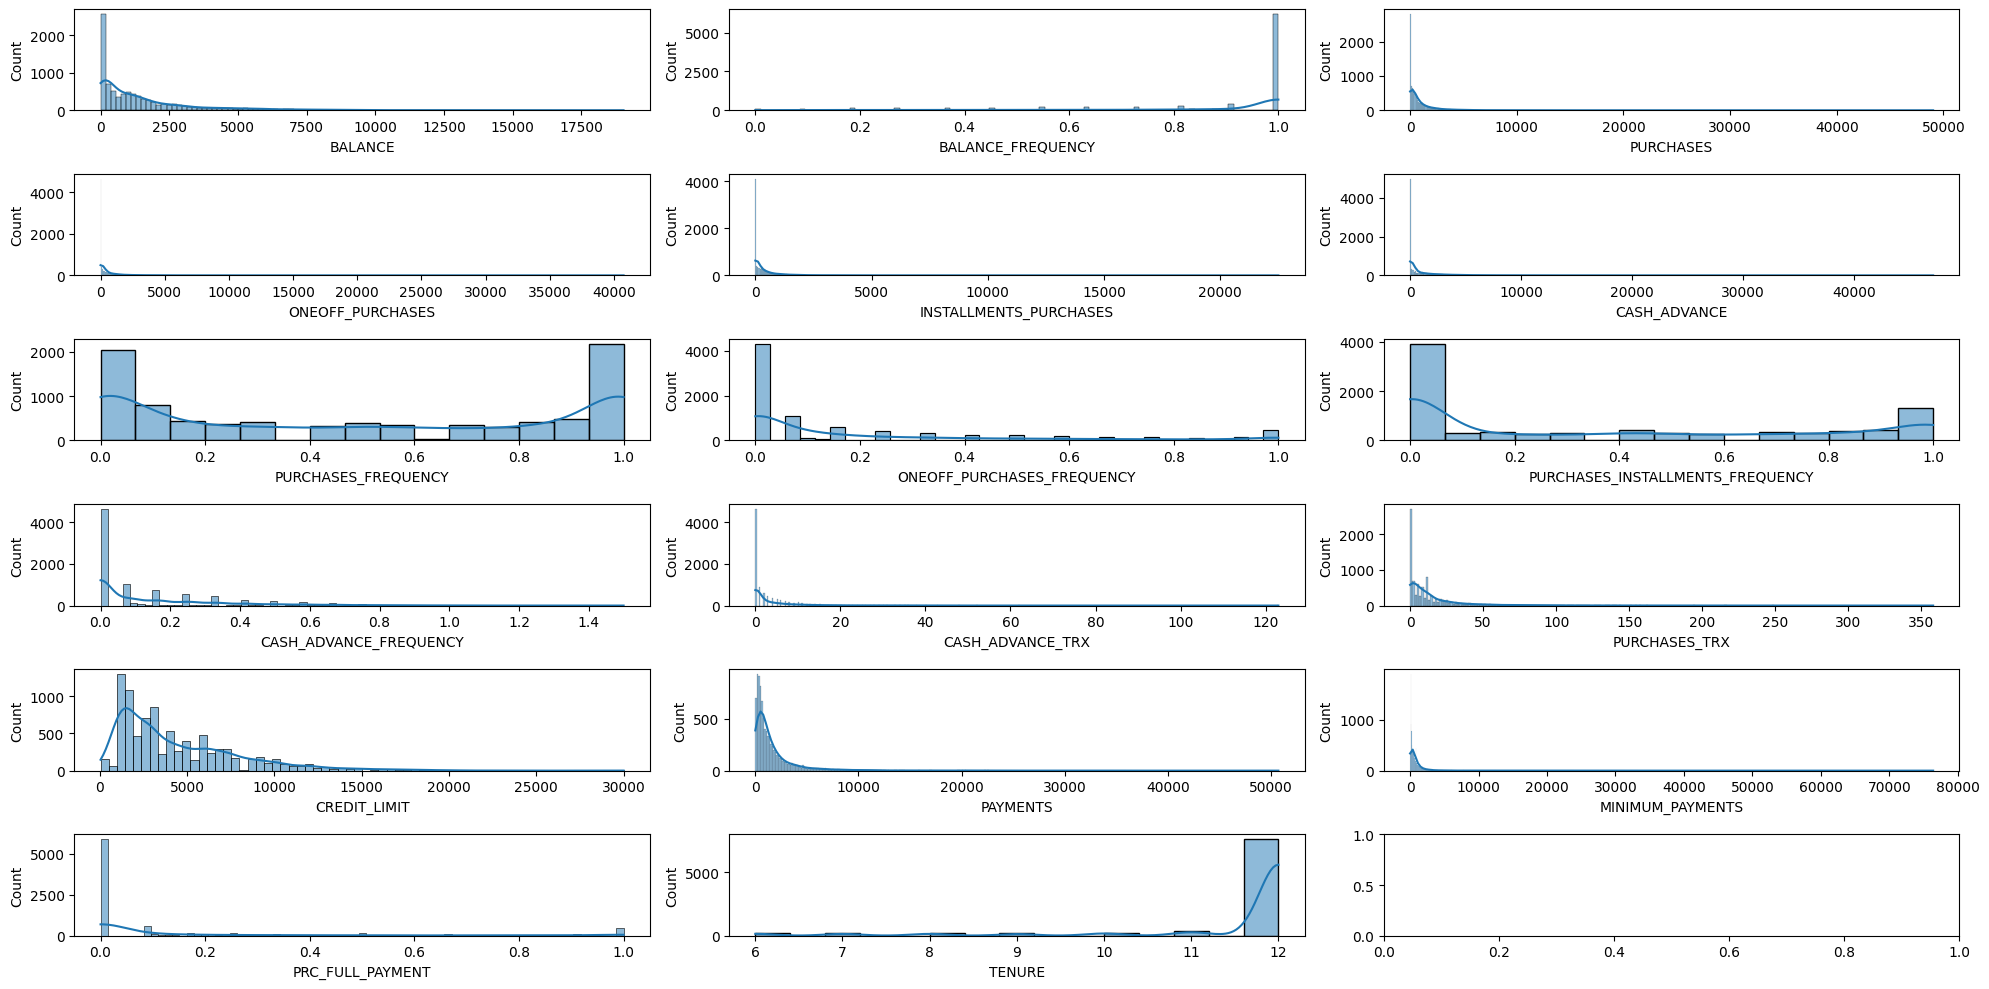

In [198]:
## EDA
plot_cols = df.columns[1:] #18

fig, axes = plt.subplots(6,3, figsize = (20, 10))

for i, axes in enumerate(axes.flat[: len(plot_cols)]) :
  col_i = df[plot_cols].columns[i]

  sns.histplot(df[col_i], kde = True, ax = axes)

plt.tight_layout()
plt.show()

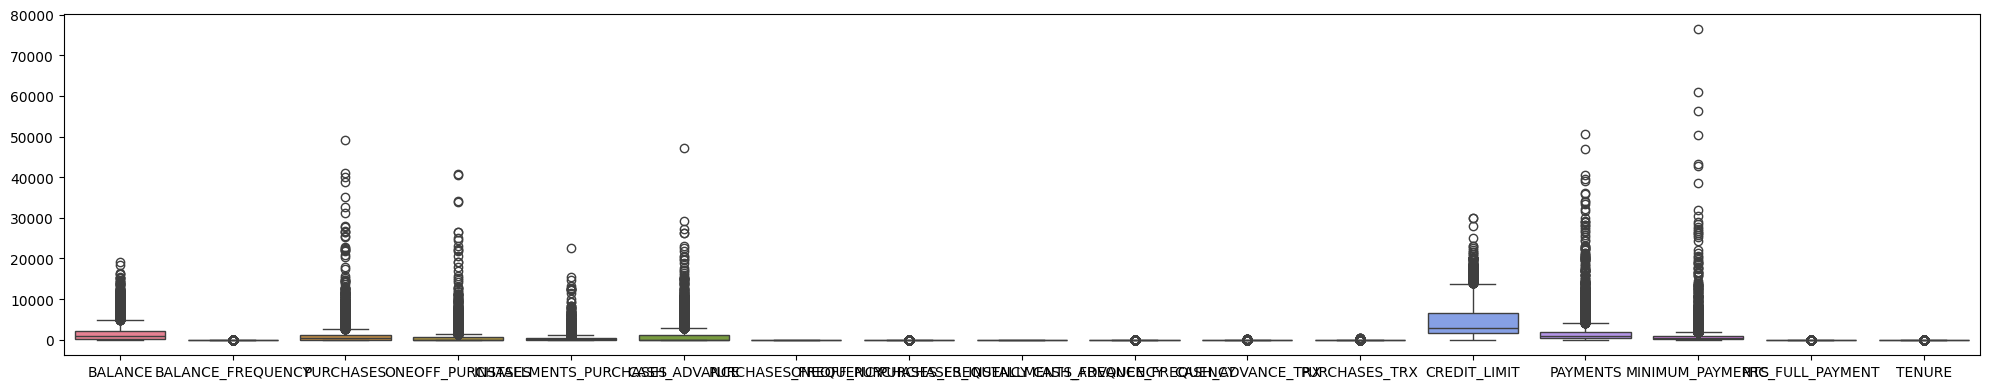

In [180]:
## 이상치 확인
plt.figure(figsize = (20, 4))
sns.boxplot(df[plot_cols])
plt.tight_layout()
plt.show()

In [199]:
# 이상치 Cliiping

def outlier(df) :
  num_cols = df.select_dtypes(exclude = 'object').columns
  df2 = df.copy()

  for col in num_cols :
    q1 =  df[col].quantile(0.25)
    q3 =  df[col].quantile(0.75)
    iqr = q3 - q1

    lower = q1 - iqr * 1.5
    upper = q3 + iqr * 1.5

    df2[col] = df[col].clip(lower = lower, upper = upper)
  return df2

df2 = outlier(df)

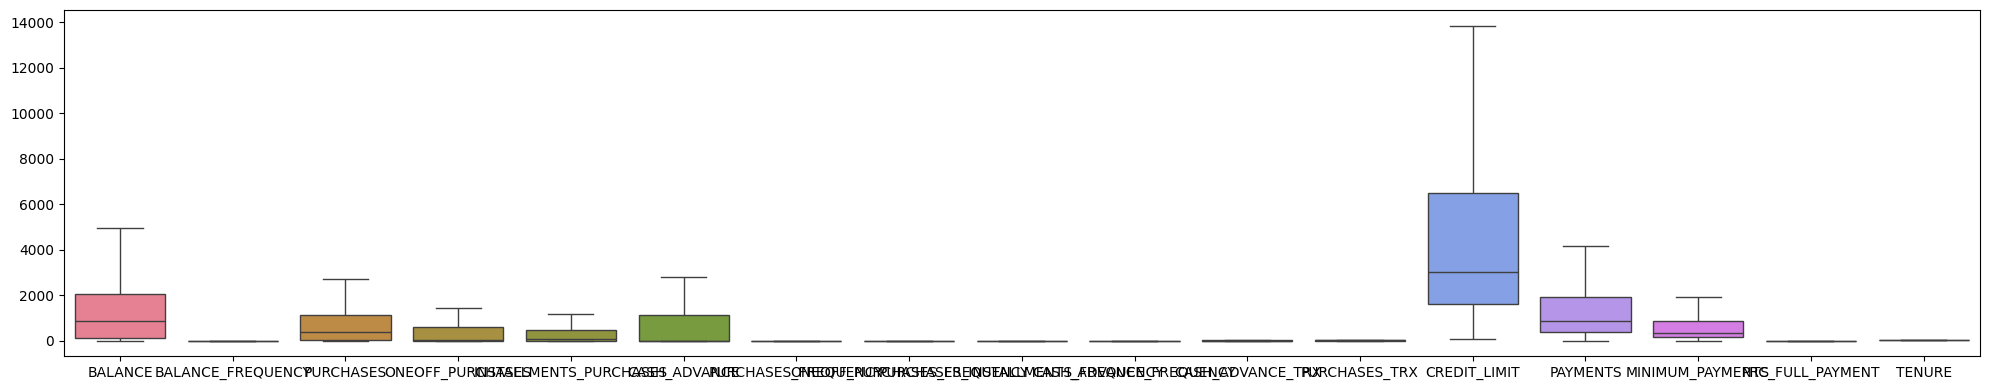

In [200]:
## 이상치 확인
plt.figure(figsize = (20, 4))
sns.boxplot(df2[plot_cols])
plt.tight_layout()
plt.show()

#### ✅ 2.2 PCA

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
Ratio,0.2729,0.20302,0.08792,0.07480,0.062628,0.057502,0.048872,0.042575,0.038288,0.030800,0.023719,0.017736,0.014265,0.012174,0.010130,0.002670,6.852235e-07
cumsum,0.2729,0.47592,0.56384,0.63864,0.701268,0.758770,0.807642,0.850217,0.888505,0.919305,0.943024,0.960760,0.975025,0.987199,0.997329,0.999999,1.000000e+00


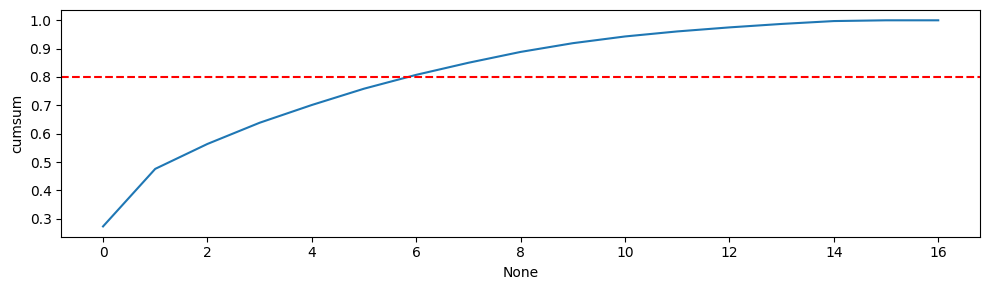


PCA 분석 결과 6-7개의 주성분이 데이터의 85%까지 설명을 한다. PCA를 통해 주성분을 통해 다중 공선성과 변수의 
변수들 간의 상관관계가 높아 변수 간 독립성 가정이 꺠지는 문제를 해결할 수 있을 것이라고 보여진다. 




In [211]:
df2 = df.drop(columns = 'CUST_ID', axis = 1)

from sklearn.preprocessing  import StandardScaler
from sklearn.decomposition import PCA

ss = pd.DataFrame(StandardScaler().fit_transform(df2), columns = df2.columns)

pca = PCA()
pca.fit(ss)

pca_res_df = pd.DataFrame({
    'Ratio' : pca.explained_variance_ratio_,
    'cumsum' :  pca.explained_variance_ratio_.cumsum()
})

display(pca_res_df.T)

plt.figure(figsize = (10, 3))
sns.lineplot(x= pca_res_df.index, y= pca_res_df['cumsum'])
plt.axhline(0.8, color ='red', linestyle = '--')

plt.tight_layout()
plt.show()

print('''
PCA 분석 결과 6-7개의 주성분이 데이터의 85%까지 설명을 한다. PCA를 통해 주성분을 통해 다중 공선성과 변수의
변수들 간의 상관관계가 높아 변수 간 독립성 가정이 꺠지는 문제를 해결할 수 있을 것이라고 보여진다.

''')

#### ✅ 2.3 Cluster

Text(0.5, 1.0, 'Silhouette_Score')

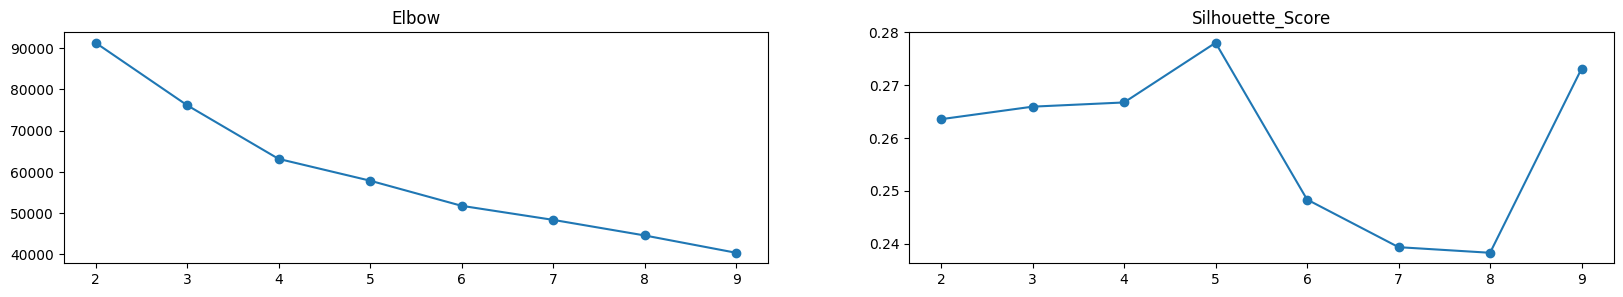

In [226]:
pca = PCA(n_components= 6)
pca_6 = pd.DataFrame(pca.fit_transform(ss) , columns = ['PC_' + str(x) for x in range(6)])


from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


elbow = []
sil = []
for k in range(2, 10) :
  km = KMeans(k)
  km.fit(pca_6)
  label = km.predict(pca_6)
  elbow.append(km.inertia_)
  sil.append(silhouette_score(pca_6, km.labels_))


# Elbow
fig, axes = plt.subplots(1, 2, figsize = (20, 3))

axes[0].plot(range(2, 10), elbow, marker='o')
axes[0].set_title('Elbow')

axes[1].plot(range(2, 10), sil, marker='o')
axes[1].set_title('Silhouette_Score')

KElbowVisualizer(ax=<Axes: >, estimator=KMeans(n_clusters=9), k=(1, 10))

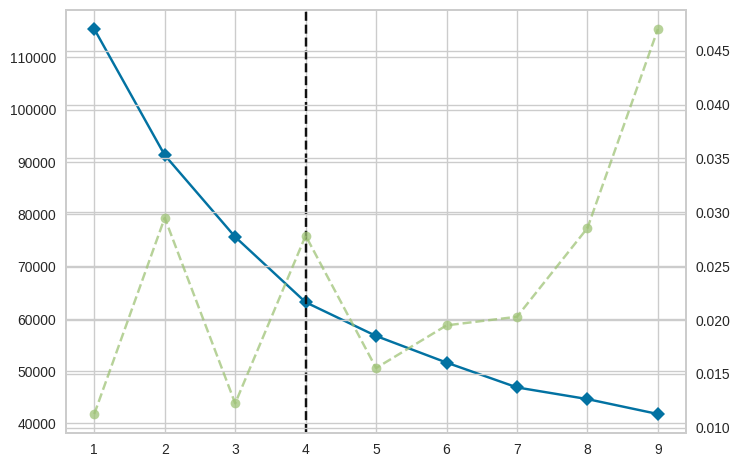

In [228]:
from yellowbrick.cluster import KElbowVisualizer
kmean = KMeans()
plot = KElbowVisualizer(kmean, k = (1, 10))
plot.fit(pca_6)

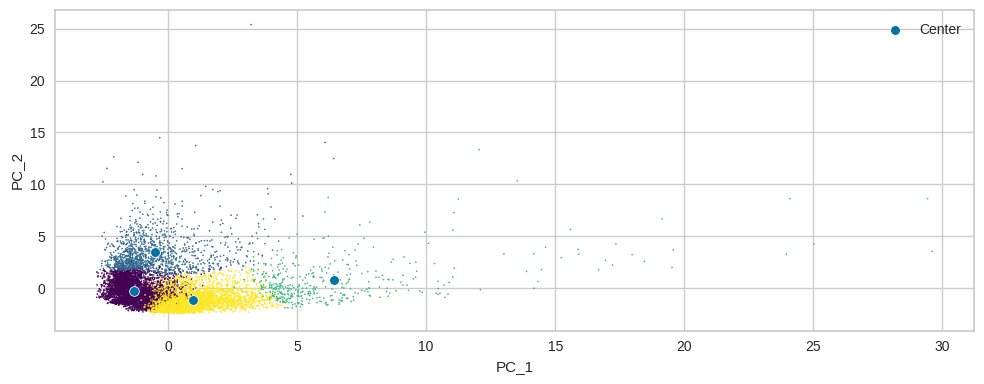

In [240]:
#응집도와 분리도를 기반으로 적절 클러스터 숫자를 구하고 두개의 주성분 차원에 군집 중심을 포함하여 시각화
km_4 = KMeans(n_clusters= 4, random_state= 34)
km_4.fit(pca_6)
km_label = km_4.predict(pca_6 )
pca_6['Label'] = km_label


plt.figure(figsize = (10,4))
# 주성분 데이터에 Label 분포도
plt.scatter(pca_6['PC_0'] , pca_6['PC_1'], c = pca_6['Label'], cmap = 'viridis', s = 0.7)

# 각 Cluster의 중심 부분 표시
sns.scatterplot(x = km_4.cluster_centers_[:,0],y =km_4.cluster_centers_[:,1],label='Center')
plt.xlabel('PC_1')
plt.ylabel('PC_2')

plt.tight_layout()
plt.show()

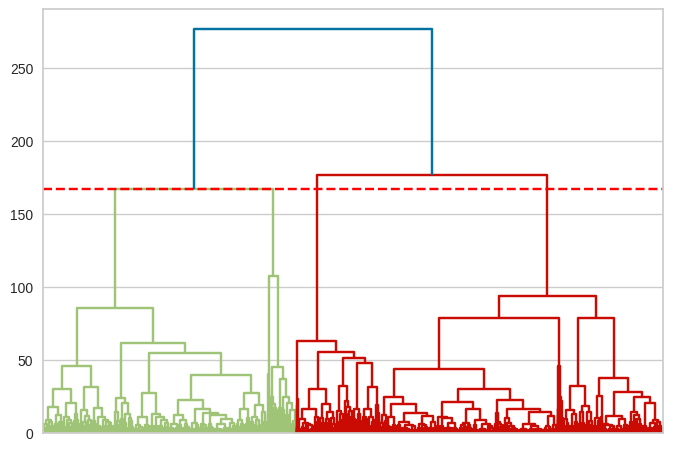

In [242]:
from scipy.cluster.hierarchy import dendrogram, linkage

lnk = linkage(pca_6, 'ward')
dend = dendrogram(lnk)
# KMeans에서 k=4가 적절하다고 판단했을 경우, 4개의 군집이 생기는 **거리 임계값(threshold)**
n_cluster = 4
# 마지막에서 3번째 거리 → 4개 군집이 만들어지는 순간
threshold = lnk[-(n_cluster -1), 2]

plt.axhline(y=threshold, color='red', linestyle='--', label=f"{n_cluster} clusters cutoff")
plt.xticks([])
plt.show()

#### 📌 통계문제
##### ✅  1. 어느 자동차 회사의 본사에서 여러 지방 영업소에 내려보낸 43대의 새 차 중 11대에 불량 오디오가 설치되었다고 한다. 어느 영업소가 8대를 인수하였는데 이 중에서 오디오가 불량인 차가 적어도 2대 이상이 될 확률

In [243]:
from scipy.stats import hypergeom

rv = hypergeom(43, 11, 8)
# 적어도 2대 이상 1- P(X = 1)
1 - rv.cdf(1)

np.float64(0.6721384488647228)

##### ✅  2. 센서 데이터
      * 변수들의 다중공선성을 검토
      * 다중공선성 문제를 해결하기 위한 방법 2가지를 제시하고, 하나를 선택하여 적용
      * 2-2의 방법을 전,후의 회귀 분석 모델의 결과를 비교

In [259]:
df = pd.read_csv('/content/drive/MyDrive/ADP_SONY/ADP_SET_1/data/stats_reg1.csv')
df.head()

target = df.drop(columns = 'Target', axis = 1)

,col1,col2,corr
12,F_1,F_13,0.840241
74,F_5,F_15,0.707201
161,F_11,F_12,0.955086
175,F_12,F_11,0.955086
180,F_13,F_1,0.840241
214,F_15,F_5,0.707201


<Axes: >

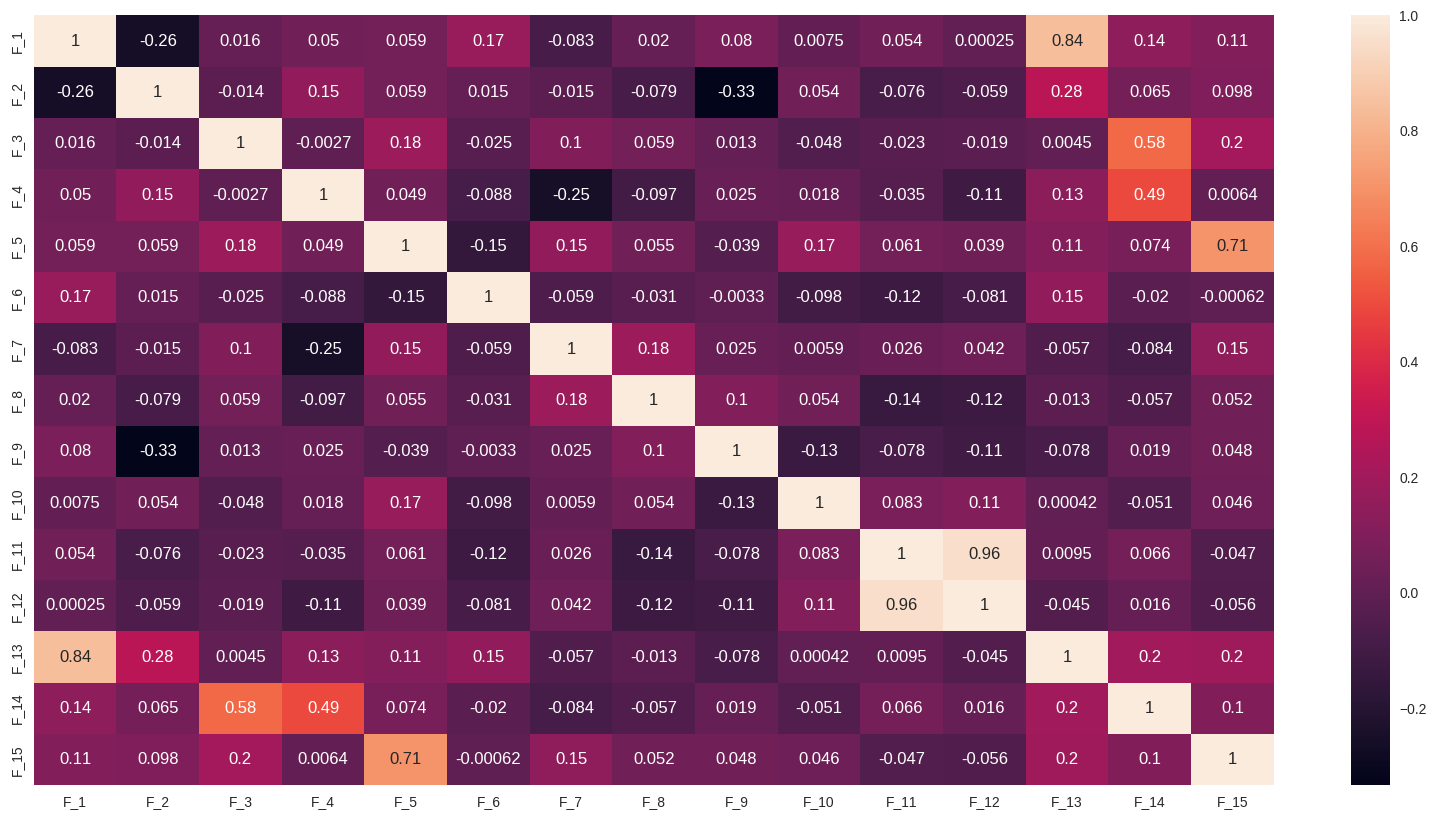

In [268]:
#1 ) 상관관계
cor_mat = target.corr()
cor_mat_unstack = cor_mat.unstack().reset_index()
cor_mat_unstack.columns = ['col1','col2','corr']

# 상관관계 0.7 이상
display(cor_mat_unstack[(cor_mat_unstack['col1'] != cor_mat_unstack['col2']) & (np.abs(cor_mat_unstack['corr']) >= 0.7)].drop_duplicates(keep = 'first') )

plt.figure(figsize = (20, 10))
sns.heatmap(cor_mat, annot= True)

In [264]:
#2 ) 다중 공선성
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
vif['Variable'] = target.columns

vif['VIF'] = [variance_inflation_factor(target.values, i) for i in range(target.shape[1])]
vif.sort_values('VIF', ascending= False)

,Variable,VIF
11,F_12,141.201961
10,F_11,139.715210
12,F_13,46.388666
0,F_1,44.238222
1,F_2,14.524559
9,F_10,5.828291
13,F_14,2.840278
14,F_15,2.294972
4,F_5,2.195660
2,F_3,2.101471


In [274]:
# 다중공선성 문제를 해결하기 위한 방법 2가지를 제시하고, 하나를 선택하여 적용 - 컬럼 삭제 혹은 PCA
drop_df = target.drop(columns = ['F_12','F_11', 'F_13','F_1', 'F_2'], axis = 1)

ss = StandardScaler()
drop_scaled_df = pd.DataFrame(ss.fit_transform(drop_df) , columns = drop_df.columns)

vif = pd.DataFrame()
vif['Variable'] = drop_scaled_df.columns

vif['VIF'] = [variance_inflation_factor(drop_scaled_df.values, i) for i in range(drop_scaled_df.shape[1])]
display(vif.sort_values('VIF', ascending= False))

,Variable,VIF
8,F_14,2.412900
2,F_5,2.219388
9,F_15,2.118694
0,F_3,1.897007
1,F_4,1.685568
4,F_7,1.141447
7,F_10,1.070048
3,F_6,1.065946
5,F_8,1.060263
6,F_9,1.042023


In [281]:
# 2-2의 방법을 전,후의 회귀 분석 모델의 결과를 비교
# 전
import statsmodels.api as sm

X = target.copy()
y = df['Target']
add_x = sm.add_constant(X)
model = sm.OLS(y, add_x).fit()
print(model.summary().tables[1])

                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0314      0.039      0.814      0.418      -0.045       0.108
F_1           61.6675      0.064    957.009      0.000      61.539      61.796
F_2           28.6933      0.035    825.633      0.000      28.624      28.762
F_3           50.7597      0.015   3371.303      0.000      50.730      50.790
F_4           63.1688      0.013   5010.118      0.000      63.144      63.194
F_5           83.1993      0.012   7090.507      0.000      83.176      83.223
F_6           16.0561      0.011   1471.039      0.000      16.034      16.078
F_7            0.6330      0.010     65.170      0.000       0.614       0.652
F_8           98.1078      0.010   9903.423      0.000      98.088      98.127
F_9           81.7976      0.009   8905.585      0.000      81.779      81.816
F_10           0.0016      0.013      0.123      0.9

In [282]:
X2 = drop_scaled_df.copy()
y = df['Target']
add_x2 = sm.add_constant(X2)
model = sm.OLS(y, add_x2).fit()
print(model.summary().tables[1])

                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         10.9706      5.697      1.926      0.057      -0.349      22.290
F_3           34.8221      7.847      4.438      0.000      19.231      50.413
F_4           61.0852      7.396      8.259      0.000      46.389      75.782
F_5           95.3672      8.487     11.237      0.000      78.503     112.231
F_6           24.6646      5.882      4.193      0.000      12.977      36.352
F_7           -3.3873      6.087     -0.557      0.579     -15.481       8.707
F_8           93.2447      5.866     15.895      0.000      81.589     104.901
F_9           81.7433      5.816     14.056      0.000      70.188      93.299
F_10           2.0532      5.893      0.348      0.728      -9.656      13.763
F_14          14.1844      8.850      1.603      0.113      -3.399      31.768
F_15           9.6821      8.292      1.168      0.2

##### ✅  3. 정규성, 등분산

In [283]:
df = pd.read_csv('/content/drive/MyDrive/ADP_SONY/ADP_SET_1/data/learn.csv')
df.head()


,Student,Lecture,Online,Blended
0,1,8.7,67.8,74.2
1,2,18.2,97.2,76.5
2,3,7.5,74.8,69.1
3,4,39.7,62.3,68.4
4,5,73.4,84.9,84.5


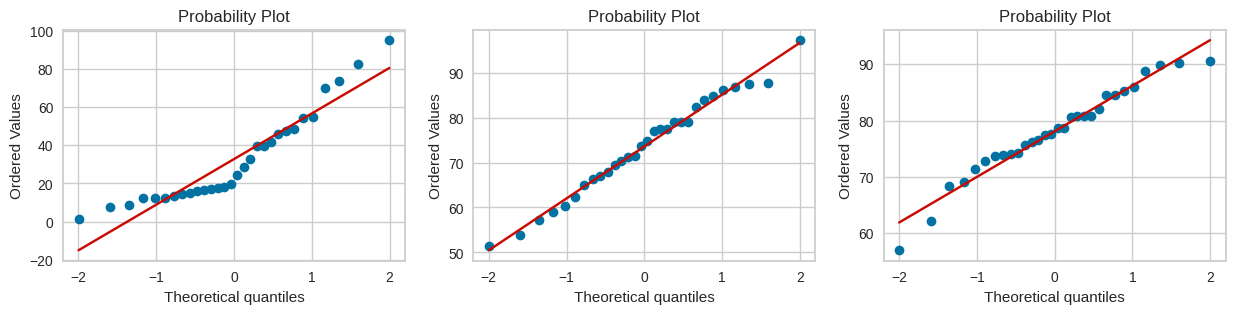

정규성 검정

귀무가설 : 정규분포이다.
대립가설 : 정규분포가 아니다. 
   Columns  Shapiro_P_value
0  Lecture         0.004650
1   Online         0.909854
2  Blended         0.363978
online과 Blended 데이터만 정규분포이다. 

등분산 검정

귀무가설 :세 그룹은 동일한 분산을 가진다
대립가설 : 세 그룹 중 적어도 하나는 분산이 다르다. 
5.894135513581264e-05 세 그룹 중 적어도 하나는 분산이 다르다.. 


In [317]:
# 3가지 방식 각각 점수 분포가 정규성을 만족하는지와 방식들간의 분산은 동일한지 검정

from scipy.stats import shapiro, levene
import scipy.stats as stats

s_df = df.iloc[:,1:]

s_lst = []
fig, axes = plt.subplots(1, 3, figsize=(15, 3))

for i ,col in enumerate(s_df.columns.unique()):
  stat, p_val = shapiro(s_df[col])
  s_lst.append([col, p_val])
  stats.probplot(s_df[col], dist='norm', plot=axes[i])


plt.show()

shapi = pd.DataFrame(s_lst , columns = ['Columns','Shapiro_P_value'])
print('정규성 검정')
print(f'''
귀무가설 : 정규분포이다.
대립가설 : 정규분포가 아니다.
{shapi}
online과 Blended 데이터만 정규분포이다. ''' )



stat, p_val = levene(s_df['Lecture'], s_df['Online'], s_df['Blended'])
print('')
print('등분산 검정')
print(f'''
귀무가설 :세 그룹은 동일한 분산을 가진다
대립가설 : 세 그룹 중 적어도 하나는 분산이 다르다.
{p_val} 세 그룹 중 적어도 하나는 분산이 다르다.. ''' )

| 항목                    | Kruskal-Wallis                             | Friedman                                         |
|-------------------------|--------------------------------------------|--------------------------------------------------|
| **검정 대상**           | 독립된 그룹 간 차이 검정                   | 반복 측정된 그룹 간 차이 검정                    |
| **유사한 모수 분석법**  | 일원분산분석 (One-way ANOVA)               | 반복측정분산분석 (Repeated Measures ANOVA)       |
| **샘플 간 관계**        | 독립 (Independent samples)                 | 관련 있음 (Repeated measures, 동일 대상 반복 측정) |
| **적용 예시**           | 서로 다른 학생 그룹 간 성적 비교           | 같은 학생에게 3가지 수업 방식 적용 후 성적 비교  |
| **데이터 형태**         | 긴 형식 (long) 또는 넓은 형식 (wide) 모두 가능 | 넓은 형식 (wide format) 선호 (`pandas.DataFrame`) |


In [321]:
# 비모수 검정 - 3개의 독립된 그룹 - 프리드만
# Krusal L 중앙값 차이가 있는지를 검정

from scipy.stats import friedmanchisquare

stat, p = friedmanchisquare(
    df['Lecture'],
    df['Online'],
    df['Blended']
)

print(f"Friedman 검정 통계량: {stat:.4f}, p-value: {p:.4f}")
print('''
귀무가설 : 3 가지 방법 간의 차이가 없다
대립가설 : 3 가지 방법 간의 차이가 있다.
p_value 0.000 < 0.05 으로 귀무가설을 기각하여, 3 가지 방법 간의 차이가 있다

''')

Friedman 검정 통계량: 33.8000, p-value: 0.0000

귀무가설 : 3 가지 방법 간의 차이가 없다
대립가설 : 3 가지 방법 간의 차이가 있다. 
p_value 0.000 < 0.05 으로 귀무가설을 기각하여, 3 가지 방법 간의 차이가 있다




In [320]:
from scipy.stats import kruskal

stat, p = kruskal(
    df['Lecture'],
    df['Online'],
    df['Blended']
)

print(f"Kruskal-Wallis 검정 통계량: {stat:.4f}, p-value: {p:.4f}")

Kruskal-Wallis 검정 통계량: 43.4142, p-value: 0.0000
